In [1]:
import glob
import pandas            as pd
import numpy             as np

from invisible_cities.database.load_db import DataSiPM

from csth.images.IMAGE          import IMAGE
from csth.utils.photopeak_fit   import pkfit, pkpdf
from csth.images.imageDataFrame import corrected_track_dataframe
imdf = corrected_track_dataframe

import matplotlib.pyplot as plt

In [6]:
# # Plotting style
default_cmap = "viridis"
figure_size  = 15, 5
# font_size    = 14

# plt.rcParams["figure.figsize"]  = figure_size
# plt.rcParams[  "font.size"   ]  = font_size
# plt.rcParams[  "image.cmap"  ]  = default_cmap
# plt.rcParams["axes.facecolor"]  = 'ghostwhite'
# #plt.rcParams["axes.grid"     ]  = True
# plt.rcParams["grid.color"    ]  = 'lightgrey'
# plt.rcParams["axes.formatter.limits"] = -4, 4
# plt.rcParams["font.family"]='serif'

# #plt.style.use(plt.style.available[10])
nbins = 1000

In [7]:
def plottext(res, cov, n):
    mus, smus = int(round(res.x[0])), int(round(cov[0][0]**.5))
    mub, smub = int(round(res.x[1])), int(round(cov[1][1]**.5))
    s, ss     = res.x[2], cov[2][2]**.5
    mu, smu   = int(round(res.x[3])), int(round(cov[3][3]**.5))
    sig, ssig = int(round(res.x[4])), int(round(cov[4][4]**.5))

    tres = (fr'$\mu_s    = {mus}\pm{smus}$' + '\n' +
            fr'$\mu_b    = {mub}\pm{smub}$' + '\n' +
            fr'$E_{{ph}} = {mu} \pm {smu}$' + '\n' +
            fr'$\sigma   = {sig} \pm {ssig}$' + '\n'+
            fr'Total Entries: {n}')
    return tres


def fitplot(E, lims, res, cov, nbins, include_single_pdfs = False):
    a, b =lims
    fig = plt.figure()
    ax = fig.add_subplot(111)

    h, _, _ = ax.hist(E, bins=int(nbins), alpha=0.5, histtype='step', color='darkblue', linewidth=2);
    e = np.linspace(a, b, 1000)
    
    pdf, fs, fb = pkpdf(e, res.x, [a,b])
    norm_scale  = ((b-a)/nbins*len(E))
    
    ax.plot(e, norm_scale*pdf, c='black')
    
    if include_single_pdfs:
        f = res.x[0]/(res.x[0] + res.x[1])
        ax.plot(e, f*norm_scale*fs     ,  c='red'   )
        ax.plot(e, (1-f)*norm_scale*fb ,  c='green' )

    ax.text(a, h.max()/2., s=plottext(res, cov, len(E)))

    ax.set_xlabel('Energy (pes)');
    ax.set_ylabel('Entries');
    fig.show()

## Th double escape events

In [8]:
run              = 6817
clarice_out_dir  = "/home/gonzalo/Documentos/NEXT/ICAROSNB/GDL/DATA/"

clarice_filename = glob.glob(clarice_out_dir + f"cepks_{run}_*")[0]

df               = pd.read_hdf(clarice_filename, key='esum')

<IPython.core.display.Javascript object>


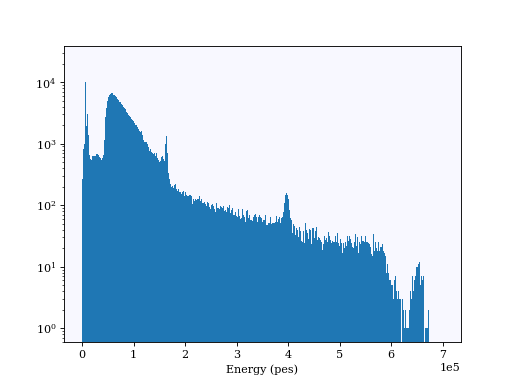

In [9]:
fig, ax = plt.subplots()
ax.hist(df.e, log=True, bins=1000, range=(0,7e5));
ax.set_xlabel('Energy (pes)')
fig.show()

In [10]:
a , b = 3.7e5, 4.3e5 
thde  = df[ (a <= df.e) & (df.e <= b) ]

E     = thde.e.values

#fit 
x0 = np.array([.5*len(E), .5*len(E), 0, np.mean(E), np.std(E)])
res, cov = pkfit(E, [a,b], x0=x0)

/home/gonzalo/anaconda3/envs/IC-3.6-2018-11-14/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/gonzalo/anaconda3/envs/IC-3.6-2018-11-14/lib/python3.6/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


Optimization terminated successfully.
         Current function value: 88161.126532
         Iterations: 18
         Function evaluations: 2035


<IPython.core.display.Javascript object>


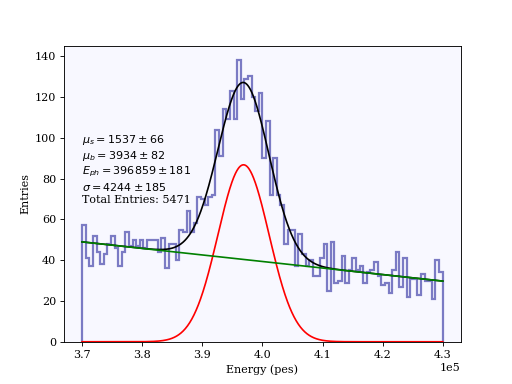

In [11]:
fitplot(E, [a, b], res, cov, nbins=.1*nbins, include_single_pdfs=True)

In [12]:
from scipy.integrate import quad

c, r = (a+b)/2., 1/(b-a)

def pdf(E, mus, mub, s, mu, sig):
    return mus/(mus+mub)*fs(E, mu, sig) + mub/(mus+mub)*fb(E, s)

def fb(E, s):
    return s*(E-c) + r

def fs(E, mu, sig):
    #A, _ = quad(gauss, a, b, args=(mu, sig))
    A = sig*(2*np.pi)**(1/2.)
    return (1/A)*gauss(E, mu, sig)

def gauss(E, mu, sig):
    return np.e**(-(E-mu)**2/(2*sig**2))

In [13]:
mus, mub, s, mu, sig = [*res.x]
f = res.x[0]/(res.x[0]+res.x[1])

eps = 3
ap, bp = mu-eps*sig, mu+eps*sig

It = quad(pdf, ap, bp, args=(res.x[0], res.x[1], res.x[2], res.x[3], res.x[4]))[0]

N = len(E)-len(E)*(quad(fb, a, ap, args=(s))[0] + quad(fb, bp, b, args=(s))[0])*(1-f)

Nb = N * (1-f)*quad(fb, ap, bp, args=(s))[0]/It

Ns = N - Nb

Ns, mus

(1535.2011142092836, 1537.3907054885779)

## Corrected track

In [203]:
events, peaks, locs = thde.event.values, thde.peak.values, thde.location.values

idx = int(np.random.random()*len(events))
print(idx)

4771


In [204]:
input_filename      = glob.glob(f"/home/gonzalo/Documentos/NEXT/DATA/{run}/pmaps_{locs[idx]:04}_{run}_*")[0]
correction_filename =           f"/home/gonzalo/Documentos/NEXT/DATA/maps/kr_corrections_run{run}.h5"
event               = events[idx]
peak                = peaks [idx]
q0min               = 6

In [205]:
imagedf = imdf(run, input_filename, correction_filename, event, peak=peak, q0min=6)

processing  /home/gonzalo/Documentos/NEXT/DATA/6817/pmaps_10363_6817_trigger2_v0.9.9_20190111_krth1600.h5


<IPython.core.display.Javascript object>


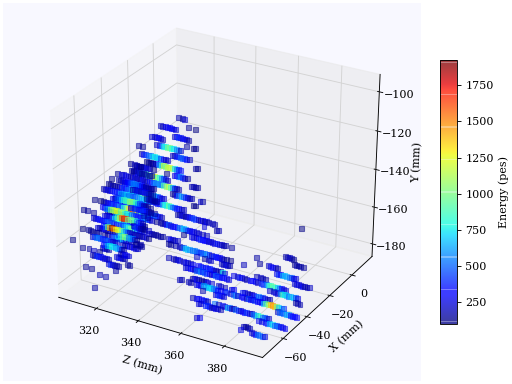

In [206]:
datasipm = DataSiPM('new', run)
im = IMAGE(imagedf, datasipm, run, event, typo='Tlde')
im.plot3d()
im.fig.show();

## Voxelization

**1) Track translation to be centered in point (0, 0, 0)**

CM: Center of Mass

OF: Original Frame of reference

CMF: CM Frame of reference, CMF = OF - CM


**2) Set frame size and voxel size**

frame_size: size in mm of the frame where the track is centered

voxel_size: voxel size in mm 

**3) Check if the track is inside the frame**

Here we can stablish an energy thresold, such as if the energy outside the frame is below, the event is accepted


**4) Voxelize with histogram**

In [207]:
hits = imagedf.copy()

In [208]:
def translation_to_CMF(hits_OF):
    '''It return the hits dataframe translated to the center of mass frame 
    of reference'''
    
    #copy original dataframe to modify in function
    hits_CMF = hits_OF.copy()
    
    #center of mass in the original frame of reference
    CM_OF = np.sum(hits_OF[['X', 'Y', 'Z']].values.T * hits_OF['E'].values, axis=1)/np.sum(hits_OF['E'])

    #translation
    hits_CMF.X = hits_CMF.X - CM_OF[0]
    hits_CMF.Y = hits_CMF.Y - CM_OF[1]
    hits_CMF.Z = hits_CMF.Z - CM_OF[2]
    
    return hits_CMF

In [209]:
def number_of_voxels(frame_size: np.array,
                     voxel_size: np.array):
    '''Given frame_size and voxel_size, returns the number of
    bins in each dimension. If not posible, it returns an error'''
    
    #remainder for each dimension
    remainder = frame_size % voxel_size
    
    if remainder.sum()>0: raise ValueError('Sizes not allowed')
    
    return (frame_size/voxel_size).astype(int)


def range_for_histogram(frame_size: np.array):
    
    '''Given frame_size, it return the range (edges) to introduce 
    in numpy.histogramdd. Since it is assumed CM frame of reference,
    the range will be a half of the frame_size'''
    
    #remainder for each dimension
    remainder = frame_size % 2
    
    if remainder.sum()>0: raise ValueError('Sizes not allowe')
    
    return [(-fs/2, +fs/2) for fs in frame_size]


def 

In [210]:
#param
frame_size    = np.array([100, 100, 100])
voxel_size    = np.array([10 , 10 , 5 ])

In [211]:
# histogram of voxels
hits = translation_to_CMF (hits)
bins = number_of_voxels   (frame_size, voxel_size)
rg   = range_for_histogram(frame_size)

#track inside limits


H, edges = np.histogramdd(hits[['X', 'Y', 'Z']].values, bins=bins, range=rg, weights=hits['E'].values)

<IPython.core.display.Javascript object>


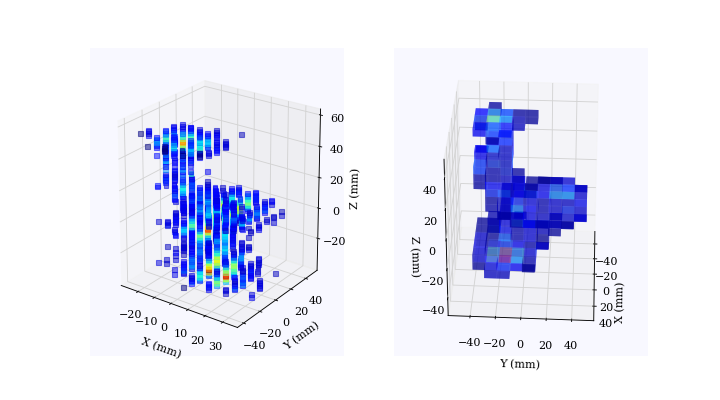

In [212]:
## Plot track in center of mass frame and voxelized image

from mpl_toolkits.mplot3d    import Axes3D


fig      = plt.figure(figsize=[9,5])
ax_track = fig.add_subplot(121, projection='3d')
ax_voxel = fig.add_subplot(122, projection='3d')


#3d track
X, Y, Z, E = hits['X'].values, hits['Y'].values, hits['Z'].values, hits['E'].values
track = ax_track.scatter(X, Y, Z, s=20, c=E, marker='s', alpha=0.5, cmap='jet')
ax_track.set_xlabel('X (mm)');
ax_track.set_ylabel('Y (mm)');
ax_track.set_zlabel('Z (mm)');


#3d voxelized track
import matplotlib as mpl
import matplotlib.cm as cm

norm = mpl.colors.Normalize(vmin=H.min(), vmax=H.max())
cmap = cm.jet
m    = cm.ScalarMappable(norm=norm, cmap=cmap)

colors = []
for h in H:
    colors.append(m.to_rgba(h, alpha=0.5))
colors= np.array(colors)

x, y, z = edges[0], edges[1], edges[2]
y, x, z = np.meshgrid(y, x, z)
filled  = H>0

# fig      = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

ax_voxel.voxels(x, y, z, filled, facecolors=colors);
ax_voxel.set_xlabel('X (mm)');
ax_voxel.set_ylabel('Y (mm)');
ax_voxel.set_zlabel('Z (mm)');

fig.show()